<a href="https://colab.research.google.com/github/sassm1t/Detection-of-Clickbait-titles-using-deep-learning/blob/main/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from google.colab import drive

# specify GPU
device = torch.device("cuda")

In [ ]:

drive.mount('/content/drive')

path = "/content/drive/MyDrive/Colab Notebooks/content/merged_data.csv"
df_bonus = pd.read_csv(path)

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/content/merged_data.csv")
print(df)



Mounted at /content/drive
                                                headline  clickbait
0                                     Should I Get Bings          1
1          Which TV Female Friend Group Do You Belong In          1
2      The New "Star Wars: The Force Awakens" Trailer...          1
3      This Vine Of New York On "Celebrity Big Brothe...          1
4      A Couple Did A Stunning Photo Shoot With Their...          1
...                                                  ...        ...
43712  To take on BJP, Trinamool likely to call meet ...          0
43713  Kolkata: Four bodies found in field, no witnes...          0
43714    Womans body found, Kolkata police await autopsy          0
43715  Jewellery stores in Kolkata raided for accepti...          0
43716         Kolkata: Fire at paper godown, no casualty          0

[43717 rows x 2 columns]


In [ ]:
# check class distribution
df['clickbait'].value_counts(normalize = True)

0    0.50509
1    0.49491
Name: clickbait, dtype: float64

In [ ]:
# Split train dataset
train_text, temp_text, train_labels, temp_labels = train_test_split(df['headline'], df['clickbait'],
                                                                  random_state=2018,
                                                                  test_size=0.3,
                                                                  stratify=df['clickbait'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

<Axes: >

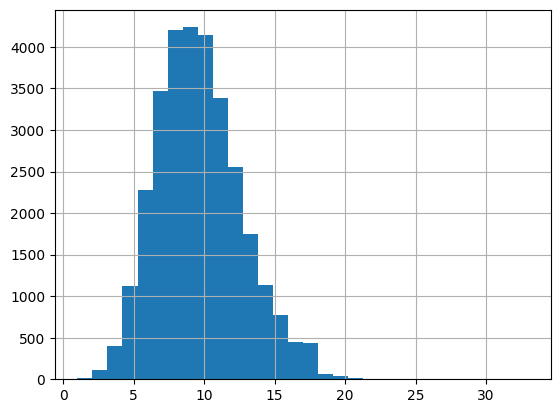

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertModel, BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Specify GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
path = "/content/drive/MyDrive/Colab Notebooks/content/merged_data.csv"
df = pd.read_csv(path)
print(df)

# Check class distribution
df['clickbait'].value_counts(normalize=True)

# Split train dataset
train_text, temp_text, train_labels, temp_labels = train_test_split(
    df['headline'], df['clickbait'],
    random_state=2018,
    test_size=0.3,
    stratify=df['clickbait'])

val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text, temp_labels,
    random_state=2018,
    test_size=0.5,
    stratify=temp_labels)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length=25,
    padding=True,
    truncation=True
)

# Tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length=25,
    padding=True,
    truncation=True
)

# Tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length=25,
    padding=True,
    truncation=True
)

# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Define a batch size
batch_size = 32

# Wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
val_data = TensorDataset(val_seq, val_mask, val_y)
test_data = TensorDataset(test_seq, test_mask, test_y)

# Samplers
train_sampler = RandomSampler(train_data)
val_sampler = SequentialSampler(val_data)
test_sampler = SequentialSampler(test_data)

# DataLoaders
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Load the BERT model
bert = BertModel.from_pretrained("bert-base-uncased")

class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_hs = outputs.last_hidden_state[:, 0, :]  # Use the first token's output (CLS token)
        x = self.fc1(cls_hs)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Initialize the model
model = BERT_Arch(bert)
model = model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 50
best_val_loss = float('inf')
counter = 0
patience = 4

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    accuracy = correct_predictions / total_predictions

    print(f'Epoch {epoch + 1}:')
    print(f'  Training Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}')

    # Validation loop
    model.eval()
    total_correct = 0
    total_samples = 0
    val_loss = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    val_loss /= len(val_dataloader)
    val_accuracy = total_correct / total_samples

    print(f'  Validation Loss: {val_loss:.4f} | Accuracy: {val_accuracy:.4f}')

    # Update learning rate
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    scheduler.step(val_loss)

    # Checkpoint model if validation loss improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model state
if best_val_loss is not None:
    model.load_state_dict(torch.load('best_model.pt'))

# Evaluate on the test set
model.eval()
total_correct = 0
total_samples = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask)
        _, predicted = torch.max(outputs, 1)

        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_accuracy = total_correct / total_samples
print(f'Test Accuracy: {test_accuracy:.4f}')

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=['Non-clickbait', 'Clickbait']))


                                                headline  clickbait
0                                     Should I Get Bings          1
1          Which TV Female Friend Group Do You Belong In          1
2      The New "Star Wars: The Force Awakens" Trailer...          1
3      This Vine Of New York On "Celebrity Big Brothe...          1
4      A Couple Did A Stunning Photo Shoot With Their...          1
...                                                  ...        ...
43712  To take on BJP, Trinamool likely to call meet ...          0
43713  Kolkata: Four bodies found in field, no witnes...          0
43714    Womans body found, Kolkata police await autopsy          0
43715  Jewellery stores in Kolkata raided for accepti...          0
43716         Kolkata: Fire at paper godown, no casualty          0

[43717 rows x 2 columns]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

KeyboardInterrupt: 